# Data Collection
---

Problem statement: Build a model that can identify periods of upwelling on the Washington and Oregon coasts using environmental data collected by bulk meteorology and shallow profiler instrument packages. 

In [8]:
# Imports

import numpy as np
# import pickle

import sys, os
# import shutil
import xarray as xr
import pandas as pd
import cmocean.cm as cmo
import requests
import re
import datetime as dt
import seaborn as sns

from netCDF4 import Dataset, num2date, date2num 
from datetime import datetime, timedelta
from numpy import datetime64 as dt64, timedelta64 as td64
from matplotlib import pyplot as plt

In [9]:
sns.set()

Website to get credentials: https://ooinet.oceanobservatories.org/

In [10]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = 'OOIAPI-xxx'
API_TOKEN = 'TEMP-TOKEN-xxx'
data_dir = '../data/'
output_dir = '../output/'

Set up output and data directories - don't want to upload these files to GitHub though!
Also, it sounds like Don from the UW OOI office already has the CEO4 data saved and organized as zarr files (can be opened using xarray) and it would save a lot of time to get them from him!

---
# Following along with the Endurance coastal upwelling notebook nugget

### Pull data 

Start by looking at just a small selection of the data available:
* pull from the shallow at Oregon Offshore location (CE04)
* start with the CTD-O instrument 
* March-June 2017 - ended up pulling all of 2017
* look at 200m platform data later! 

The following two functions were provided by the OOI to request and download data.

In [11]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

In [12]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]).replace("\\","/") for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        url_with_fillmismatch = f'{sd}#fillmismatch'
        ds = xr.open_dataset(url_with_fillmismatch, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Use the `request_data` function to request data from the OOI. These requests will output a URL where your requested data is stored; this URL also gets sent to the email associated with your OOI account. The URLs don't expire so I've saved them in the file `data_urls.txt` for use again later! Below are examples of the requests I put in, but they don't need to be run again. 

In [13]:
# METBK_url = request_data('CE04OSSM-SBD11-06-METBKA000', 'recovered_host', 
#                          'metbk_a_dcl_instrument_recovered',
#                          '2017-01-01T00:00:00.000Z', '2017-12-31T12:00:00.000Z')
# print('METBK_url: %s' %METBK_url)

In [14]:
# CTD_url = request_data('CE04OSPS-SF01B-2A-CTDPFA107', 'streamed', 'ctdpf_sbe43_sample',
#                         '2017-01-01T00:00:00.000Z', '2017-12-31T12:00:00.000Z')
# print('CTD_url: %s' %CTD_url)

Here are two URLs that have data for the year 2017. We can use these to load in data files. Putting these URLs into your browser window will bring you to the OPeNDAP server where you can see variable names and descriptions. There are a lot of folders to navigate through, but [here](https://opendap.oceanobservatories.org/thredds/dodsC/ooi/deryag@uw.edu/20210422T030848056Z-CE04OSPS-SF01B-2A-CTDPFA107-streamed-ctdpf_sbe43_sample/deployment0004_CE04OSPS-SF01B-2A-CTDPFA107-streamed-ctdpf_sbe43_sample_20170801T160709.510843-20170916T121340.481090.nc.html) is an example of the CTD data, and [here](https://opendap.oceanobservatories.org/thredds/dodsC/ooi/deryag@uw.edu/20210422T030752259Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/deployment0006_CE04OSSM-SBD11-04-VELPTA000-recovered_host-velpt_ab_dcl_instrument_recovered_20180403T183000-20180403T183000.nc.html) is an example of the METBK data. You can navigate to these examples using the URLs below by selecting a .nc folder and then clicking on the OPeNDAP link. 

In [15]:
METBK_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210422T030752259Z-CE04OSSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'

CTD_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/deryag@uw.edu/20210422T030848056Z-CE04OSPS-SF01B-2A-CTDPFA107-streamed-ctdpf_sbe43_sample/catalog.html'

### Load data files

Time to actually get the data! Print a `.head()` of each dataset to make sure the data was successfully pulled. This method returns pandas dataframes. I'm considering swapping to the xarray library later but it might not be necessary.

Note to self: ask Don which CTD and METBK variables I should actually be using. There are raw measurements with specified fill values, and there are qc versions that might be better to work with.

In [16]:
# Specify the variable(s) of interest
CTD_var = ['seawater_pressure', 'density', 'practical_salinity', 'seawater_temperature', 'corrected_dissolved_oxygen', 
           'lat', 'lon']
METBK_var = ['sea_surface_temperature', 'met_windavg_mag_corr_east', 'met_windavg_mag_corr_north']

# get the data! 
CTD_data, CTD_units = get_data(CTD_url, CTD_var)
METBK_data, METBK_units = get_data(METBK_url, METBK_var)

# check the variable units
print(CTD_units)
print(METBK_units)



Appending data from files
Appending data from files
{'seawater_pressure': ['dbar'], 'density': ['kg m-3'], 'practical_salinity': ['1'], 'seawater_temperature': ['ºC'], 'corrected_dissolved_oxygen': ['µmol kg-1'], 'lat': ['degrees_north'], 'lon': ['degrees_east']}
{'sea_surface_temperature': ['ºC'], 'met_windavg_mag_corr_east': ['m s-1'], 'met_windavg_mag_corr_north': ['m s-1']}


In [22]:
# save these files as .csv so that you don't have to use `get_data()` if you accidentally overwrite your dataframes
# this takes a couple minutes to finish saving, it's a lot of data!
CTD_data.to_csv('./data/ctd_data.csv', index=False)
METBK_data.to_csv('./data/metbk_data.csv', index=False)

If you accidentally overwrite your dataframes you can run the cell below to refresh them without having to pull the data in a second time.

In [17]:
# CTD_data = pd.read_csv('./data/ctd_data.csv')
# METBK_data = pd.read_csv('./data/metbk_data.csv')

### Inspect the data
Let's see how much data we have...

In [18]:
print(CTD_data.shape)
print(METBK_data.shape)

(21517483, 8)
(485137, 4)


Lots of observations!!! We can resample the data into lower resolution later so that we aren't feeding 20M observations to our visaulizations.

See what the data looks like:

In [19]:
CTD_data

,time,seawater_pressure,density,practical_salinity,seawater_temperature,corrected_dissolved_oxygen,lat,lon
14955101,2017-01-01 00:00:00.317937152,200.479041,1027.353099,33.886699,7.785772,106.590066,44.37415,-124.95648
14955102,2017-01-01 00:00:01.318152192,200.473701,1027.353005,33.886692,7.786201,106.566439,44.37415,-124.95648
14955103,2017-01-01 00:00:02.318157312,200.467264,1027.352763,33.886432,7.786262,106.633814,44.37415,-124.95648
14955104,2017-01-01 00:00:03.317954560,200.465142,1027.352876,33.886519,7.785895,106.511052,44.37415,-124.95648
14955105,2017-01-01 00:00:04.318168576,200.466196,1027.352835,33.886425,7.785711,106.702620,44.37415,-124.95648
...,...,...,...,...,...,...,...,...
3811651,2017-09-16 12:13:36.480951808,55.887428,1026.093423,33.515015,9.740724,174.247648,44.37415,-124.95648
3811652,2017-09-16 12:13:37.480647680,55.495146,1026.091836,33.513691,9.733299,174.247264,44.37415,-124.95648
3811653,2017-09-16 12:13:38.480967680,55.449183,1026.101359,33.524510,9.725553,174.128022,44.37415,-124.95648
3811654,2017-09-16 12:13:39.480977408,55.550728,1026.101385,33.524760,9.729361,174.092489,44.37415,-124.95648


We can see that this data actually cuts off at 2017-09-16 instead of covering the entire year of 2017. No big deal.

In [20]:
METBK_data

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
325934,2017-01-01 00:00:30.432000000,11.273,4.095093e+00,-7.196688e+00
325935,2017-01-01 00:01:37.298999808,11.268,6.134961e+00,-5.290137e+00
325936,2017-01-01 00:02:41.522000384,11.267,4.501072e+00,-4.933199e+00
325937,2017-01-01 00:03:46.300000256,11.267,3.296377e+00,-4.787901e+00
325938,2017-01-01 00:04:50.525000192,11.278,4.516634e+00,-4.688541e+00
...,...,...,...,...
73128,2017-12-01 18:28:40.451000320,12.053,-1.228042e+07,-7.013654e+06
73129,2017-12-01 18:29:44.697999872,12.053,-1.228042e+07,-7.013654e+06
73130,2017-12-01 18:30:16.942000128,12.052,-1.228042e+07,-7.013654e+06
73131,2017-12-01 18:31:21.691999744,12.052,-1.228042e+07,-7.013654e+06


The bulk meteorology data goes until 2017-12-01, nice! 

Depending on the fill values for these datasets, I may need to drop zeros and negative values. I'm not concerned with how clean the data is for this initial EDA, but I'm leaving this function here to come back to later.

In [13]:
# this function can only be used if the expected values are always >0
def remove_zeros(df, variables):
    cnames = []
    for v in variables:
        if v not in ['lat', 'lon']:
            cname = v + '_ind'
            cnames.append(cname)
            df[cname] = df[v] > 0.00
    for cn in cnames:
        df = df.loc[df[cn] == True]
    df = df.drop(columns=cnames)
    return df

In [ ]:
# CTD_data = remove_zeros(CTD_data, CTD_var)
# METBK_data = remove_zeros(METBK_data, METBK_var)

Do a simple `.describe()`

In [15]:
METBK_data.describe()

,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
count,485137.000000,4.671560e+05,4.671560e+05
mean,12.504472,-1.806753e+05,-1.031858e+05
std,1.816724,1.478567e+06,8.444168e+05
min,9.854000,-1.228062e+07,-7.013654e+06
25%,10.622000,-8.175190e-01,-5.188641e+00
50%,12.163000,8.225444e-01,-1.676100e+00
75%,14.158000,2.683002e+00,3.312628e+00
max,17.580999,1.502310e+01,2.124346e+01


In [16]:
METBK_data.isna().sum()

time                              0
sea_surface_temperature           0
met_windavg_mag_corr_east     17981
met_windavg_mag_corr_north    17981
dtype: int64

I actually didn't expect to see nulls here, I thought they'd all be filled in with some standard. Will have to decide how to best fill or drop those later.

In [17]:
CTD_data.describe()

,seawater_pressure,practical_salinity,seawater_temperature,corrected_dissolved_oxygen,lat,lon
count,2.151748e+07,2.151748e+07,2.151748e+07,2.151748e+07,2.151748e+07,2.151748e+07
mean,1.892278e+02,3.382338e+01,7.923279e+00,1.032202e+02,4.437415e+01,-1.249565e+02
std,3.956323e+01,2.838685e-01,7.240315e-01,2.854860e+01,2.273737e-12,5.087486e-12
min,1.355533e+01,2.668256e+01,6.647794e+00,3.493388e+01,4.437415e+01,-1.249565e+02
25%,2.026819e+02,3.384952e+01,7.368913e+00,8.760923e+01,4.437415e+01,-1.249565e+02
50%,2.037541e+02,3.390711e+01,7.839711e+00,1.002137e+02,4.437415e+01,-1.249565e+02
75%,2.044697e+02,3.394010e+01,8.267647e+00,1.125449e+02,4.437415e+01,-1.249565e+02
max,2.906436e+02,3.402038e+01,1.545517e+01,3.261326e+02,4.437415e+01,-1.249565e+02


In [19]:
CTD_data.isna().sum()

time                          0
seawater_pressure             0
practical_salinity            0
seawater_temperature          0
corrected_dissolved_oxygen    0
lat                           0
lon                           0
dtype: int64

No nulls because they've already been filled with designated values. I'll need to check the data URLs and OPeNDAP server info to find out what the fill value is for each individual variable so I can decide how to remove these filled values later. Will probably go back to that function that fills zeros. 

---
# METBK data

The bulk meteorology package sits on a surface mooring and collects meteorological data and sea surface measurements. This is great! We want to look at wind data because coastal upwelling is a wind-driven process, and we also want to look at how variables at the sea surface change. Luckily, this package has it all! 

In [23]:
METBK_data['time']

325934   2017-01-01 00:00:30.432000000
325935   2017-01-01 00:01:37.298999808
325936   2017-01-01 00:02:41.522000384
325937   2017-01-01 00:03:46.300000256
325938   2017-01-01 00:04:50.525000192
                      ...             
73128    2017-12-01 18:28:40.451000320
73129    2017-12-01 18:29:44.697999872
73130    2017-12-01 18:30:16.942000128
73131    2017-12-01 18:31:21.691999744
73132    2017-12-01 18:32:26.453000192
Name: time, Length: 485137, dtype: datetime64[ns]

Do a quick conversion from the timestamp datatype to datetime for easier slicing later.

In [24]:
METBK_data['time'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

325934    2017-01-01 00:00:30
325935    2017-01-01 00:01:37
325936    2017-01-01 00:02:41
325937    2017-01-01 00:03:46
325938    2017-01-01 00:04:50
                 ...         
73128     2017-12-01 18:28:40
73129     2017-12-01 18:29:44
73130     2017-12-01 18:30:16
73131     2017-12-01 18:31:21
73132     2017-12-01 18:32:26
Name: time, Length: 485137, dtype: object

If I try plotting the data as is, I get a very empty plot. I think the last couple weeks of this data is funky, so let's slice is out for now. 

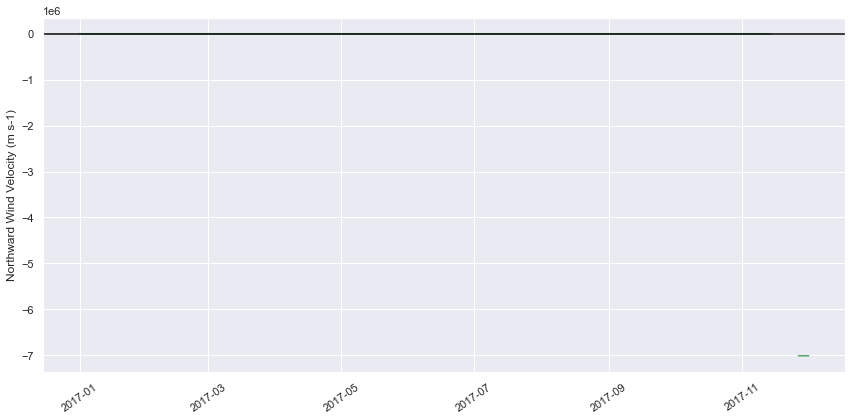

In [29]:
fig, ax = plt.subplots(1,1, sharex=True, figsize = (12, 6)) 

ax.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_north'], 'g')
ax.set_xlabel('')
ax.set_ylabel('Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]))
ax.axhline(y=0, ls='-', c='black') # add horizontal line at 0

plt.xticks(rotation=35);
plt.tight_layout()
plt.savefig('METBK_SST_NWind.png')

Slice away!

In [30]:
mask = (METBK_data['time'][:] > '2017-01-01') & (METBK_data['time'] <= '2017-11-15')
METBK_data = METBK_data.loc[mask]

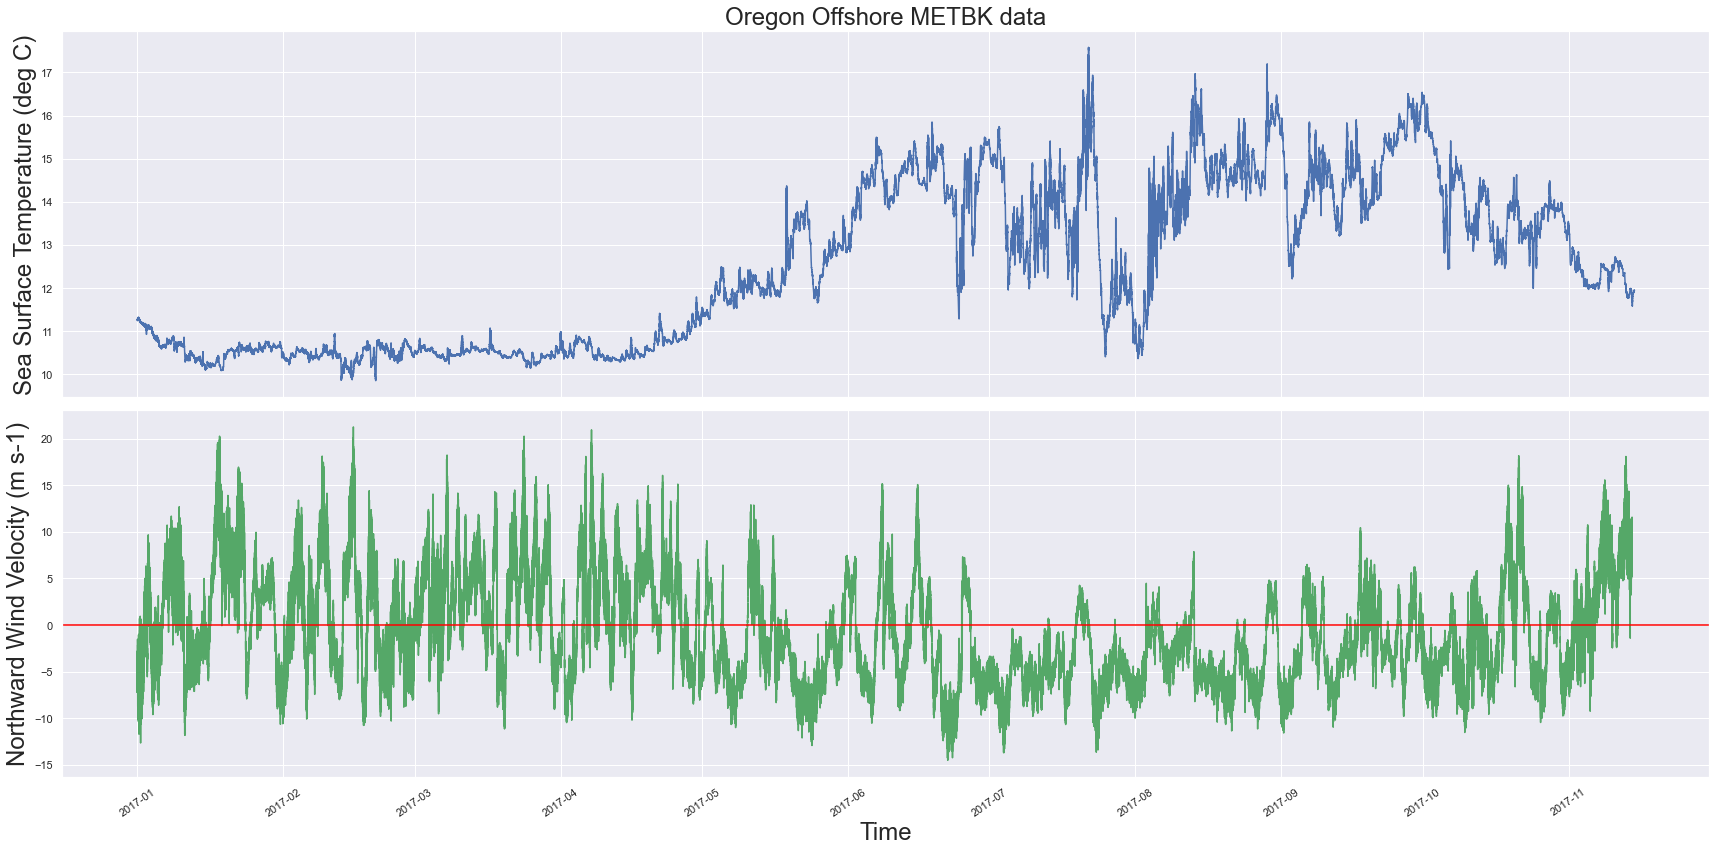

In [77]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize = (24, 12)) 
ax1.plot(METBK_data['time'], METBK_data['sea_surface_temperature'], 'b')
ax1.set_ylabel('Sea Surface Temperature (deg C)', size=24)
ax1.set_title('Oregon Offshore METBK data', size=24)

ax2.plot(METBK_data['time'], METBK_data['met_windavg_mag_corr_north'], 'g')
ax2.set_xlabel('Time', size=24)
ax2.set_ylabel('Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]), size=24)
ax2.axhline(y=0, ls='-', c='red') # add horizontal line at 0

plt.xticks(rotation=35);
plt.tight_layout()
plt.savefig('./figures/METBK_SST_NWind.png')

That looks much better! The upper subplot shows sea surface tempreature (SST) measurements throughout the year. The lower subplot shows the northward wind velocity at this location. The red horizontal line represents a northward velocity of 0. When the green line is above 0, the wind is blowing to the North, and when it's below 0 the wind is blowing to the South. Southward blowing winds cause upwelling of cold waters in this environment, so we expect to see a decrease in sea surface temperatures when the northward wind velocity is negative.

Notice how cold and stable the temperature is in the winter months, keeping between ~10 and ~11 degrees C. The sea surface begins warming up in late April and May, and is considerably warmer in the summer months. 

Next, notice how irregular the temperature is in the summer months - this is probably due to the seasonal upwelling we're looking for! The northward wind velocity is often positive in winter and spring months and often negative in summer and fall months. What we're hoping to see here is that **extended periods of negative northward wind velocities are followed by a sharp spike downward in the SST.** See if you can find spots like that in the plot above!

Keep in mind that northward wind velocity is not a perfect indicator of upwelling and that we'll need to use an official upwelling index to label our data for modeling. More on this later in the notebook.

This data has a super high temporal resolution (something to be grateful for) but we can resample it to hourly and daily means by chaining some functions. Resampling the CTD data will be more important than the METBK data, but I'll do it here anyway for consistency.

In [55]:
METBK_hourly = METBK_data.resample('H', on='time').mean().dropna(how='all').reset_index()
METBK_hourly

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
0,2017-01-01 00:00:00,11.268333,4.348728,-5.135321
1,2017-01-01 01:00:00,11.264600,4.470534,-4.484457
2,2017-01-01 02:00:00,11.257867,5.828099,-4.564354
3,2017-01-01 03:00:00,11.252350,5.794522,-7.796951
4,2017-01-01 04:00:00,11.271867,6.989749,-6.915843
...,...,...,...,...
7627,2017-11-14 19:00:00,11.903050,NaN,NaN
7628,2017-11-14 20:00:00,11.901317,NaN,NaN
7629,2017-11-14 21:00:00,11.918254,NaN,NaN
7630,2017-11-14 22:00:00,11.942672,NaN,NaN


In [56]:
METBK_daily = METBK_data.resample('D', on='time').mean().dropna(how='all').reset_index()
METBK_daily

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
0,2017-01-01,11.247412,6.413056,-5.371468
1,2017-01-02,11.149430,-1.148830,-1.207261
2,2017-01-03,11.089363,-5.203772,2.533484
3,2017-01-04,10.926763,-6.222477,-4.027738
4,2017-01-05,10.756387,-6.911579,-3.048631
...,...,...,...,...
313,2017-11-10,12.468681,-0.408066,4.630594
314,2017-11-11,12.591080,0.274552,4.486309
315,2017-11-12,12.417127,-0.501287,8.977260
316,2017-11-13,11.889144,4.022042,10.856365


The resulting dataframes have a much more manageable number of observations.

We can quickly calculate the percentage of time in 2017 that winds are blowing towards the south and get an idea of how much of the year might see favorable conditions for upwelling. Again, northward wind velocity is not the only indicator of upwelling conditions, we'll need to look at a calculated index for that later.

In [57]:
north_winds = np.array(METBK_hourly['met_windavg_mag_corr_north'])
upwelling_percentage = len(north_winds[north_winds < 0]) / len(north_winds) * 100
print('{}%'.format(round(upwelling_percentage)))

58%


Winds are blowing from North to South for about 58% of our time period! We should repeat this with our upwelling index, too, though the index data will only have daily calculations instead of by the hour.

We can zoom in on just a few months worth of data to get a closer look at negative northward wind velocities and downward spikes in sea surface temperature.

In [67]:
# Grab times of interest
mask = (METBK_hourly['time'][:] > '2017-04-01') & (METBK_hourly['time'] <= '2017-08-01')
METBK_summer_data = METBK_hourly.loc[mask]

METBK_summer_data.head()

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
2161,2017-04-01 01:00:00,10.822590,0.803592,-2.903407
2162,2017-04-01 02:00:00,10.635898,0.310431,-2.673502
2163,2017-04-01 03:00:00,10.660164,1.038492,-2.400807
2164,2017-04-01 04:00:00,10.632017,0.945587,-2.576699
2165,2017-04-01 05:00:00,10.704410,0.654626,-2.115579


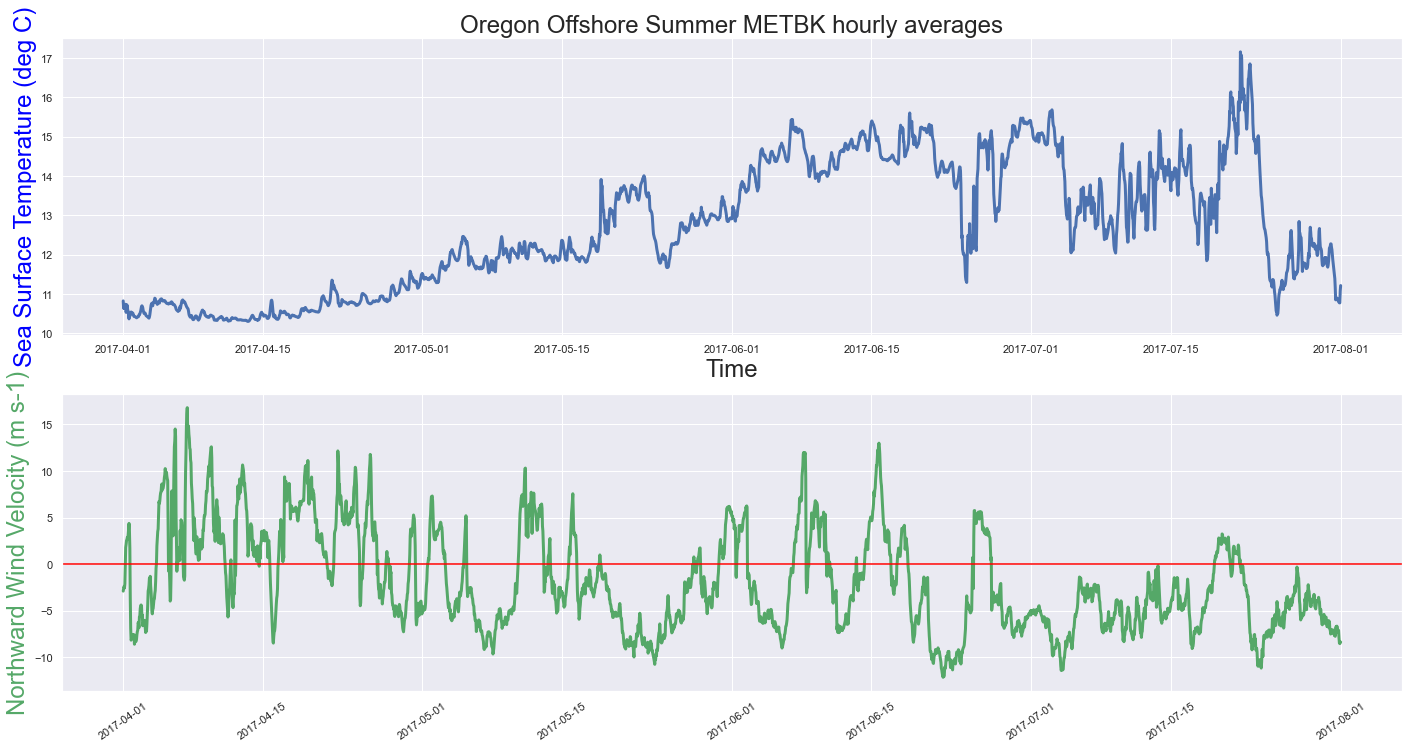

In [68]:
fig, (ax, ax2) = plt.subplots(2,1, figsize=(24, 12))

#ax2 = ax.twinx()  # instantiate a second axis that shares the same x-axis
ax.plot(METBK_summer_data['time'], METBK_summer_data['sea_surface_temperature'], 'b', linewidth=3)
ax.set_ylabel('Sea Surface Temperature (deg C)', color='blue', size=24)
ax.set_xlabel('Time', size=24)

ax2.plot(METBK_summer_data['time'], METBK_summer_data['met_windavg_mag_corr_north'], 'g', linewidth=3)
ax2.set_ylabel('Northward Wind Velocity (m s-1)', color='g', size=24)
plt.xticks(rotation=35)

ax2.axhline(y=0, ls='-', c='red') # add horizontal line at 0
ax.set_title('Oregon Offshore Summer METBK hourly averages', size=24);

Is it easier to see the connection between wind velocity and sea surface temperature now? There's a bit of a lag in time between southward blowing winds and colder temperature measurements. The relationship will be more clear when we look at the upwelling index later. 

---
# CTD data
Time to look at the CTD data collected by the shallow profiler! The profiler we're using goes up and down in the water column on a wire, from ~20 meters to ~200 meters, 9 times a day. This will give us a better picture of how the water column changes in upwelling conditions than the surface mooring holding the bulk meteorology (METBK) package.

Ever tried plotting 20M observations? Neither have I, and I don't want to start now! We can resample the CTD data to a 1 minute scale, an hourly scale, and a daily scale. I have lots of questions about whether or not this is really a good idea though. If the profiler is moving up and down through the water column on a schedule, then looking at resampled data could actually give us an incorrect impression of the temperature patterns in the water column. This is something I need to come back to later; for now, let's resample and continue on.

In [69]:
CTD_minutes = CTD_data.resample('T', on='time').mean().dropna(how='all').reset_index()
METBK_minutes = METBK_data.resample('T', on='time').mean().dropna(how='all').reset_index()
#CTD_minutes.head()

CTD_hourly = CTD_data.resample('H', on='time').mean().dropna(how='all').reset_index()
#METBK_hourly.head()
CTD_daily = CTD_data.resample('D', on='time').mean().dropna(how='all').reset_index()
#CTD_daily.head()

Now we can 

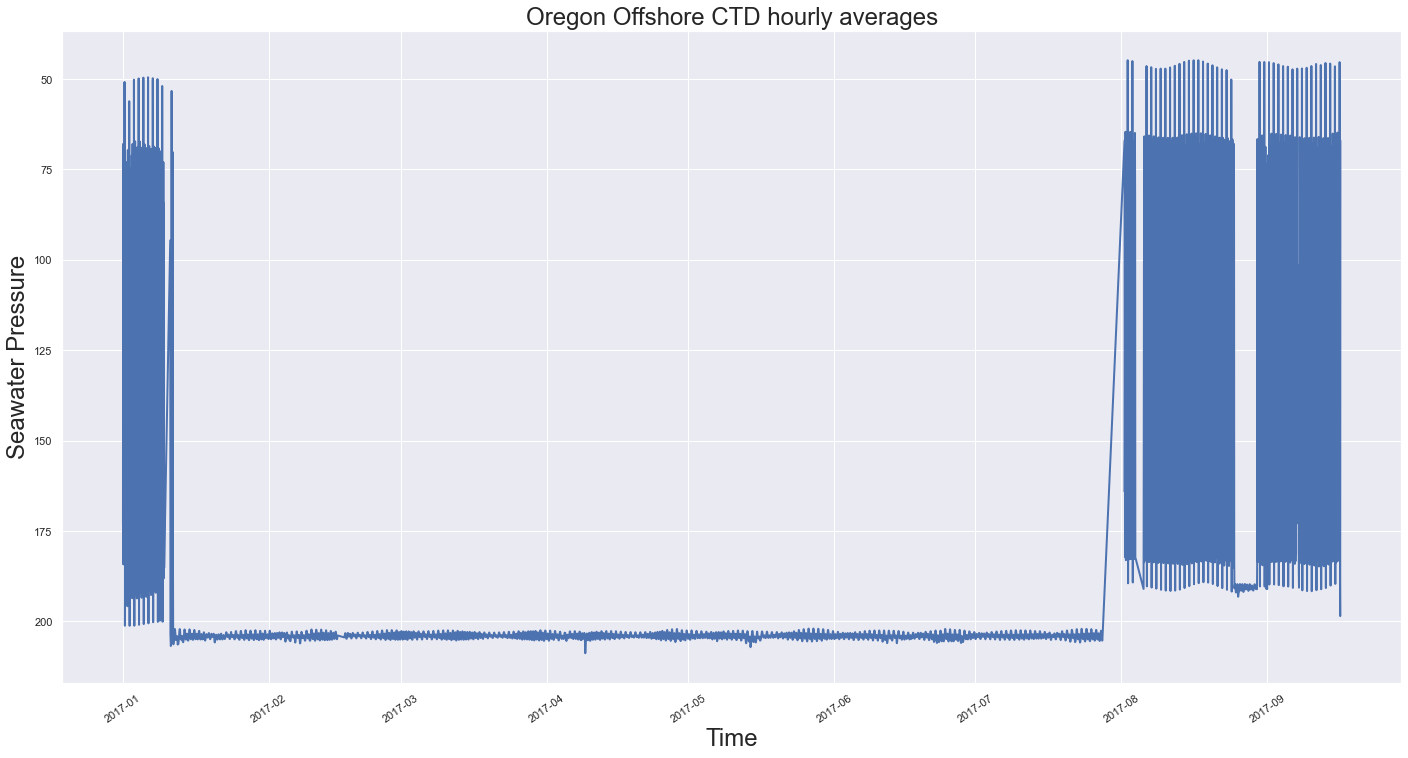

In [108]:
# Plot hourly-averaged METBK data
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(24, 12))
ax.plot(CTD_hourly['time'], CTD_hourly['seawater_pressure'], 'b', linewidth=2)
ax.set_xlabel('Time', size=24)
ax.set_ylabel('Seawater Pressure', size=24)
ax.set_title('Oregon Offshore CTD hourly averages', size=24)
ax.invert_yaxis()

plt.xticks(rotation=35);

Hmmm... the CTD data is a lot less reliable looking than the METBK data. Pulling in one of the qc seawater temperature variables might be better, I should see what Wu-Jung and Don think about this. 

To give you a better idea of what the profiler is doing, I'm going to select 5 days of data to plot.

In [97]:
mask = (CTD_data['time'][:] > '2017-08-20') & (CTD_data['time'] <= '2017-08-25')
CTD_week = CTD_data.loc[mask]

CTD_week.shape

(431988, 8)

Even 5 days of data is still almost half a million observations, wow! The cell below will take a few seconds to run

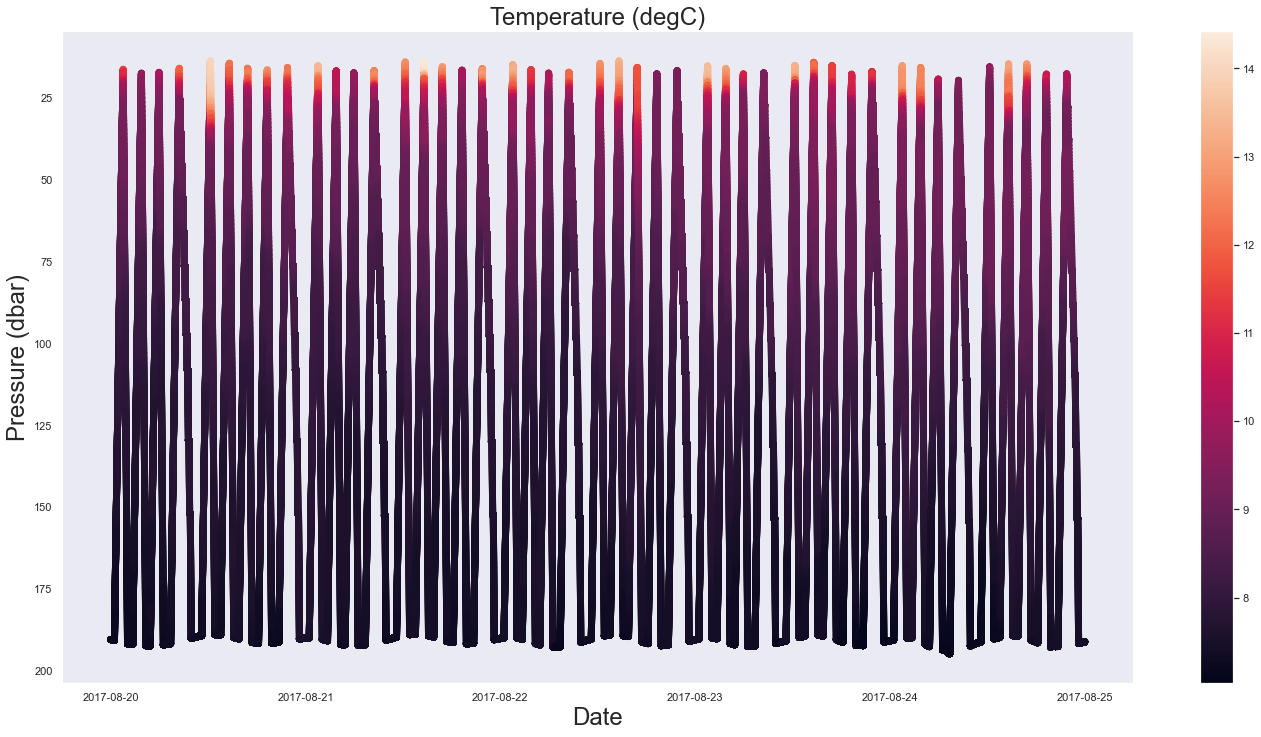

In [98]:
fig, ax = plt.subplots(figsize=(24, 12))

ax.invert_yaxis()
ax.grid()

sc = ax.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['seawater_temperature'])
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('Temperature (degC)', size=24)
cb = fig.colorbar(sc,ax=ax)

plt.savefig('./figures/CTD_profiler_5days.png')

I hope this visual helps you understand the profiler's trips up and down through the water column! The colors on this plot indicate how temperature changes with depth - warmer near the surface and colder near 200 meters. Theoretically, this temperature pattern should change when there's upwelling of cold water. When there's upwelling, we expect to see cold water closer to the surface! 

Also, did you notice how wavy the bottom edge of the profiler data is? I'm guessing the depth that the profiler can get to changes according to the position of the wire it's on, which might be impacted by tidal cycles. That would mean this wavy pattern is the daily tidal cycle! I think it's so cool that that showed up in this data even though I wasn't looking for it - just another reason that I love working with ocean data!

We can generate similar plots with salinity, dissolved oxygen, and density! Each of these variables should have a similar or identical pattern as the plot above. 

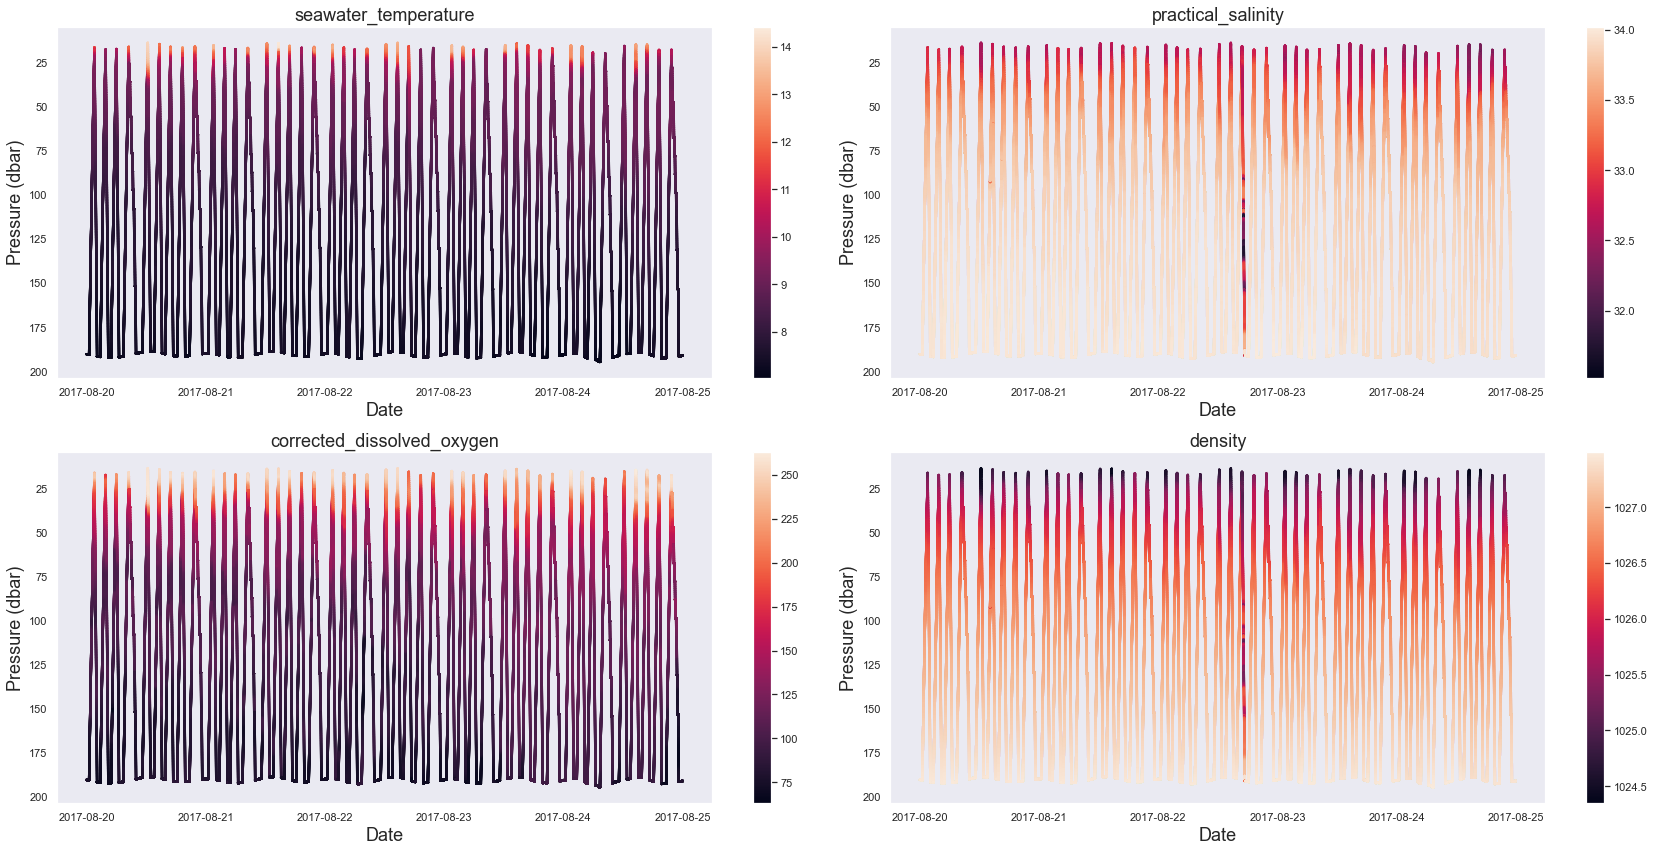

In [83]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 12))

for ax in [ax1, ax2, ax3, ax4]:
    ax.invert_yaxis()
    ax.grid()
    ax.set_xlabel('Date', size=18)
    ax.set_ylabel('Pressure (dbar)', size=18)

#ax1.set_xlim(CTD_data['time'],CTD_data['time'])
sc = ax1.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['seawater_temperature'], s=2)
cb = fig.colorbar(sc,ax=ax1)
ax1.set_title('seawater_temperature', size=18)

sc = ax2.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['practical_salinity'], s=2)
cb = fig.colorbar(sc,ax=ax2)
ax2.set_title('practical_salinity', size=18)

sc = ax3.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['corrected_dissolved_oxygen'], s=2)
cb = fig.colorbar(sc,ax=ax3)
ax3.set_title('corrected_dissolved_oxygen', size=18)

sc = ax4.scatter(CTD_week['time'],CTD_week['seawater_pressure'],c=CTD_week['density'], s=2)
cb = fig.colorbar(sc,ax=ax4)
ax4.set_title('density', size=18)

plt.tight_layout()
plt.savefig('./figures/CTD_profiler_multi.png')

We've already talked about seawater temperature. Practical salinity has an inverse relationship, where deep water is more saline than surface water. Dissovled oxygen is higher at the surface than at depth. Density is calculated from temperature and salinity, and surface water is less dense than deep water. 

There's one odd profile in the salinity measurements, which is also reflected in the calculated density data. Not sure if this is a natural anomaly or just some buggy data, but it's definitely the kind of thing I want to check for before I begin modeling things. 

Next, let's zoom out and look at a couple of the summer months of data.

In [86]:
# Grab times of interest
mask = (CTD_data['time'][:] > '2017-04-01') & (CTD_data['time'] <= '2017-08-01')
CTD_summer = CTD_data.loc[mask]

CTD_summer.shape

(10193079, 8)

Brave enough to plot 10M observations? I'm not! Let's use the 1 minute resampled dataframe we created earlier.

In [87]:
mask = (CTD_minutes['time'][:] > '2017-04-01') & (CTD_minutes['time'] <= '2017-08-01')
CTD_summer_minutes = CTD_minutes.loc[mask]

CTD_summer_minutes.shape

(169898, 8)

169K observation is a little less scary. We can plot this summer CTD data alongside our summer METBK wind data from earlier.

In [88]:
mask = (METBK_minutes['time'][:] > '2017-04-01') & (METBK_minutes['time'] <= '2017-08-01')
METBK_summer_minutes = METBK_minutes.loc[mask]

METBK_summer_minutes.shape

(162420, 4)

In [94]:
CTD_data['seawater_pressure'].describe()

count    2.151748e+07
mean     1.892278e+02
std      3.956323e+01
min      1.355533e+01
25%      2.026819e+02
50%      2.037541e+02
75%      2.044697e+02
max      2.906436e+02
Name: seawater_pressure, dtype: float64

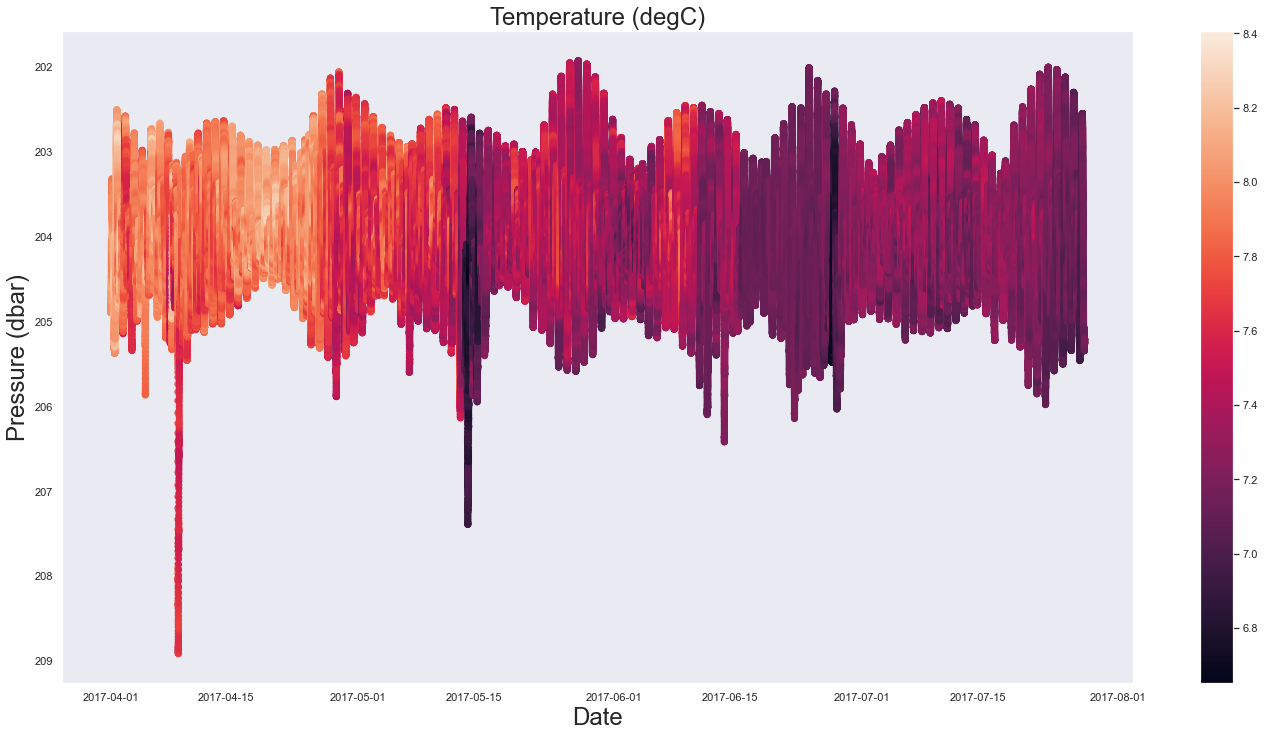

In [90]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.
# source: https://github.com/dgumustel/yodapy/blob/master/examples/yodapy_example_plots.ipynb

fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_The xlim(CTD_data['time'],CTD_data['time'])
sc = ax.scatter(CTD_summer_minutes['time'],CTD_summer_minutes['seawater_pressure'],c=CTD_summer_minutes['seawater_temperature'])
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('Temperature (degC)', size=24)
cb = fig.colorbar(sc,ax=ax)

plt.savefig('./figures/CTD_profiler_summer_temp.png')

In [102]:
mask = (CTD_minutes['time'][:] > '2017-07-01') & (CTD_minutes['time'] <= '2017-09-01')
CTD_august_minutes = CTD_minutes.loc[mask]

CTD_august_minutes.shape

(80085, 8)

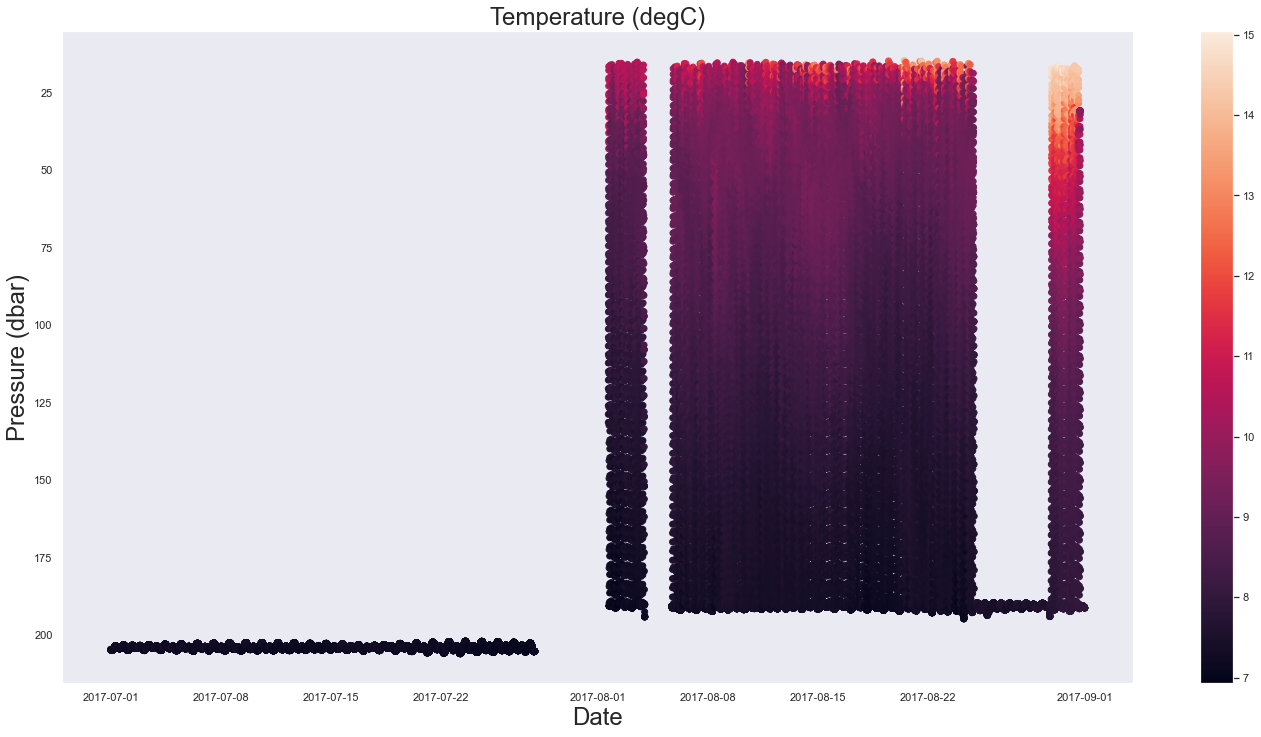

In [103]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.
# source: https://github.com/dgumustel/yodapy/blob/master/examples/yodapy_example_plots.ipynb

fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_The xlim(CTD_data['time'],CTD_data['time'])
sc = ax.scatter(CTD_august_minutes['time'],CTD_august_minutes['seawater_pressure'],c=CTD_august_minutes['seawater_temperature'])
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('Temperature (degC)', size=24)
cb = fig.colorbar(sc,ax=ax)

plt.savefig('./figures/CTD_profiler_summer_temp.png')

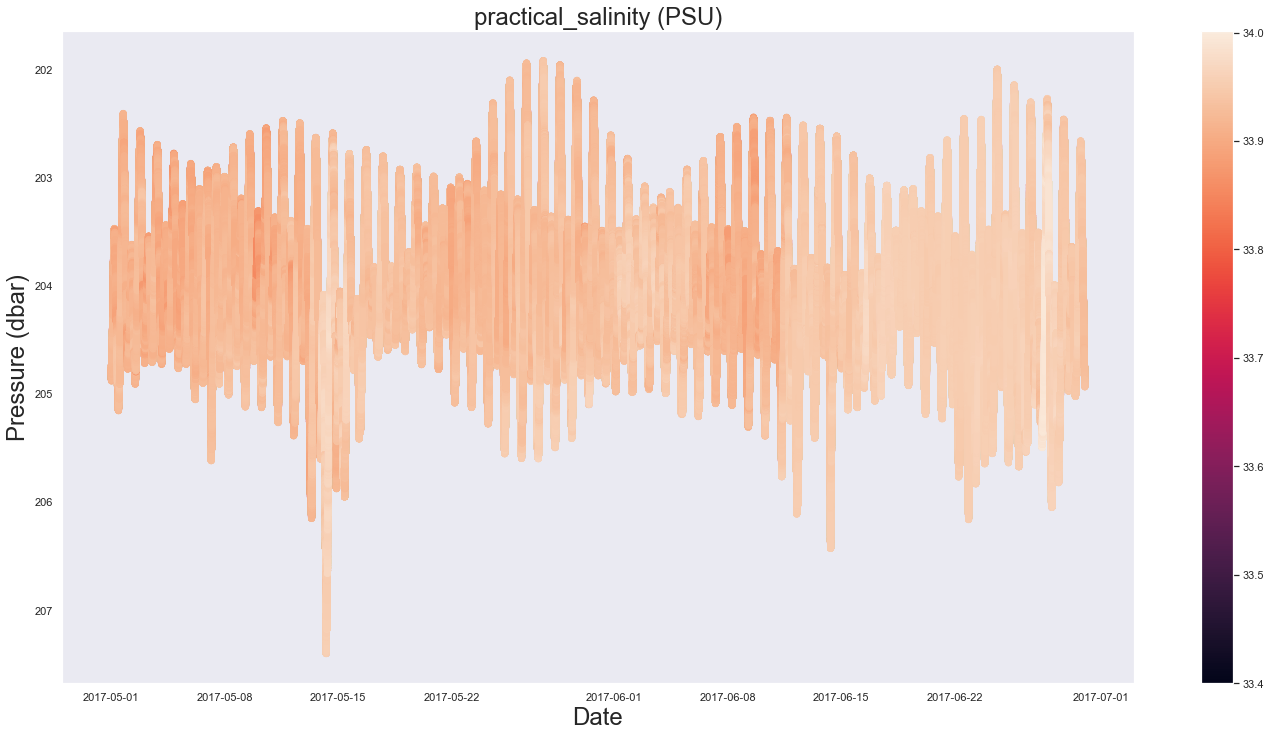

In [114]:
# Now, more complete colored scatter plot, with data plotted
# on a depth vs. time axis.
# source: https://github.com/dgumustel/yodapy/blob/master/examples/yodapy_example_plots.ipynb

fig, ax = plt.subplots(figsize=(24, 12))

# plot temp and salinity curtain plots
ax.invert_yaxis()
ax.grid()
#ax1.set_xlim(CTD_data['time'],CTD_data['time'])
sc = ax.scatter(CTD_summer['time'],CTD_summer['seawater_pressure'],c=CTD_summer['practical_salinity'], vmin=33.4)
ax.set_xlabel('Date', size=24)
ax.set_ylabel('Pressure (dbar)', size=24)
ax.set_title('practical_salinity (PSU)', size=24)
cb = fig.colorbar(sc,ax=ax)

plt.savefig('CTD_profiler_salinity.png')

In [59]:
#METBK_summer_minutes

In [60]:
METBK_summer_minutes = METBK_summer_minutes.rename(columns={'sea_surface_temperature': 'Sea Surface Temperature (deg_C)',
                                            'met_windavg_mag_corr_east': 'Eastward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_east'][0]), 
                                            'met_windavg_mag_corr_north': 'Northward Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0])})

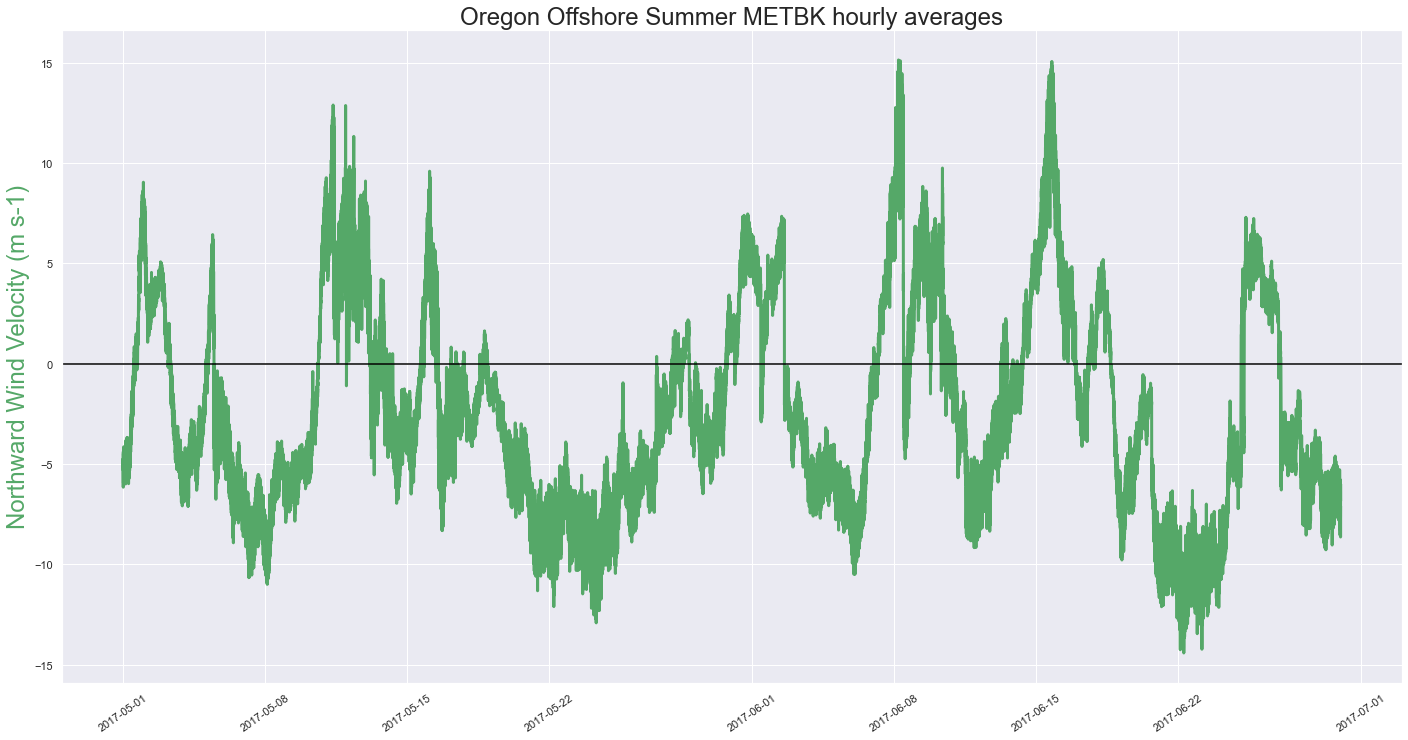

In [61]:
fig, ax = plt.subplots(figsize=(24, 12))
ax.plot(METBK_summer_minutes['time'], METBK_summer_minutes['Northward Wind Velocity (m s-1)'], 'g', linewidth=3)
ax.set_ylabel('Northward Wind Velocity (m s-1)', color='g', size=24)
plt.xticks(rotation=35)

ax.axhline(y=0, ls='-', c='black') # add horizontal line at 0
ax.set_title('Oregon Offshore Summer METBK hourly averages', size=24);

### Next up

Need to add practical salinity to variables that I pull in in order to plot the above with salinity data - this would be nice because seawater temperature and salinity are inversely related, so we expect to see the same pattern in both variables - is this what you see? 

Pull in next: 
* salinity
* dissolved oxygen
* density?
* upwelling index data

---
# Pull in CUTI index data

In [62]:
cuti = pd.read_csv('CUTI_daily.csv')

In [63]:
mask = (cuti['year'] == 2017)
cuti = cuti.loc[mask]

In [64]:
cuti

,year,month,day,31N,32N,33N,34N,35N,36N,37N,38N,39N,40N,41N,42N,43N,44N,45N,46N,47N
10593,2017,1,1,0.304,0.348,0.805,0.904,0.612,0.390,0.712,1.596,1.950,3.470,3.912,2.677,1.937,1.731,0.619,1.463,1.365
10594,2017,1,2,0.684,0.432,0.706,0.877,0.700,0.479,0.424,1.092,1.148,1.376,1.111,1.063,1.066,1.308,0.574,0.625,0.709
10595,2017,1,3,0.443,0.284,0.273,0.055,0.076,0.093,-0.186,-0.121,0.011,-0.014,-0.386,0.296,0.306,0.360,0.418,0.542,-0.171
10596,2017,1,4,0.130,0.124,0.064,-0.031,-0.588,-0.436,-0.878,0.166,0.118,0.052,-0.041,0.423,0.479,0.742,0.694,-0.226,-0.382
10597,2017,1,5,0.023,-0.029,-0.189,-0.134,-0.225,0.126,-0.098,-0.101,0.562,1.107,0.565,0.751,1.013,1.469,1.337,-0.287,-0.294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10953,2017,12,27,-0.120,0.197,-0.119,-0.043,0.519,1.084,0.554,0.645,0.379,-0.008,0.223,0.465,0.261,0.256,0.101,0.282,-0.061
10954,2017,12,28,0.013,0.048,0.076,0.394,0.055,0.269,0.626,0.410,0.493,0.157,-0.286,0.031,-0.034,0.214,-0.072,-0.110,-0.040
10955,2017,12,29,0.104,-0.038,-0.029,-0.191,0.011,0.814,0.202,-0.814,-0.113,-0.101,-0.475,-0.094,-0.472,-0.814,-1.247,-0.602,-0.099
10956,2017,12,30,-0.061,0.172,0.074,-0.441,-0.289,-0.349,-0.157,0.944,-0.082,-0.726,-0.722,-0.223,-0.458,-0.675,-0.523,-0.272,0.012


In [65]:
cuti['time'] = pd.to_datetime(cuti[['year', 'month', 'day']])

In [66]:
cuti

,year,month,day,31N,32N,33N,34N,35N,36N,37N,...,39N,40N,41N,42N,43N,44N,45N,46N,47N,time
10593,2017,1,1,0.304,0.348,0.805,0.904,0.612,0.390,0.712,...,1.950,3.470,3.912,2.677,1.937,1.731,0.619,1.463,1.365,2017-01-01
10594,2017,1,2,0.684,0.432,0.706,0.877,0.700,0.479,0.424,...,1.148,1.376,1.111,1.063,1.066,1.308,0.574,0.625,0.709,2017-01-02
10595,2017,1,3,0.443,0.284,0.273,0.055,0.076,0.093,-0.186,...,0.011,-0.014,-0.386,0.296,0.306,0.360,0.418,0.542,-0.171,2017-01-03
10596,2017,1,4,0.130,0.124,0.064,-0.031,-0.588,-0.436,-0.878,...,0.118,0.052,-0.041,0.423,0.479,0.742,0.694,-0.226,-0.382,2017-01-04
10597,2017,1,5,0.023,-0.029,-0.189,-0.134,-0.225,0.126,-0.098,...,0.562,1.107,0.565,0.751,1.013,1.469,1.337,-0.287,-0.294,2017-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10953,2017,12,27,-0.120,0.197,-0.119,-0.043,0.519,1.084,0.554,...,0.379,-0.008,0.223,0.465,0.261,0.256,0.101,0.282,-0.061,2017-12-27
10954,2017,12,28,0.013,0.048,0.076,0.394,0.055,0.269,0.626,...,0.493,0.157,-0.286,0.031,-0.034,0.214,-0.072,-0.110,-0.040,2017-12-28
10955,2017,12,29,0.104,-0.038,-0.029,-0.191,0.011,0.814,0.202,...,-0.113,-0.101,-0.475,-0.094,-0.472,-0.814,-1.247,-0.602,-0.099,2017-12-29
10956,2017,12,30,-0.061,0.172,0.074,-0.441,-0.289,-0.349,-0.157,...,-0.082,-0.726,-0.722,-0.223,-0.458,-0.675,-0.523,-0.272,0.012,2017-12-30


In [67]:
cuti.describe()

,year,month,day,31N,32N,33N,34N,35N,36N,37N,38N,39N,40N,41N,42N,43N,44N,45N,46N,47N
count,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.00000,365.000000,365.000000
mean,2017.0,6.526027,15.720548,0.609044,0.461115,0.370507,0.516510,0.656170,0.667649,0.461605,0.458197,0.714452,0.741230,0.382332,0.440364,0.270170,0.044526,-0.00937,0.057104,-0.003732
std,0.0,3.452584,8.808321,0.579076,0.393689,0.430674,0.657754,0.738901,0.848936,0.768430,0.966081,1.177748,1.223045,1.217789,1.314468,1.037623,0.809462,0.84350,0.626244,0.627815
min,2017.0,1.000000,1.000000,-0.726000,-0.417000,-0.490000,-0.773000,-1.498000,-1.727000,-2.417000,-1.801000,-2.599000,-2.642000,-3.154000,-4.413000,-3.946000,-3.996000,-4.58900,-3.085000,-2.992000
25%,2017.0,4.000000,8.000000,0.170000,0.171000,0.091000,0.042000,0.129000,0.100000,0.019000,-0.132000,-0.048000,-0.038000,-0.216000,-0.212000,-0.230000,-0.350000,-0.29700,-0.270000,-0.322000
50%,2017.0,7.000000,16.000000,0.535000,0.398000,0.258000,0.407000,0.504000,0.473000,0.316000,0.250000,0.397000,0.447000,0.223000,0.299000,0.278000,0.105000,0.06900,0.126000,0.069000
75%,2017.0,10.000000,23.000000,0.921000,0.689000,0.517000,0.827000,1.077000,1.106000,0.880000,0.920000,1.275000,1.476000,0.893000,1.142000,0.863000,0.508000,0.48100,0.426000,0.370000
max,2017.0,12.000000,31.000000,2.777000,2.136000,2.152000,3.588000,3.956000,4.986000,5.325000,7.151000,8.001000,6.436000,6.209000,6.505000,4.487000,2.517000,2.18100,1.768000,1.987000


In [68]:
cuti.isna().sum()

year     0
month    0
day      0
31N      0
32N      0
33N      0
34N      0
35N      0
36N      0
37N      0
38N      0
39N      0
40N      0
41N      0
42N      0
43N      0
44N      0
45N      0
46N      0
47N      0
time     0
dtype: int64

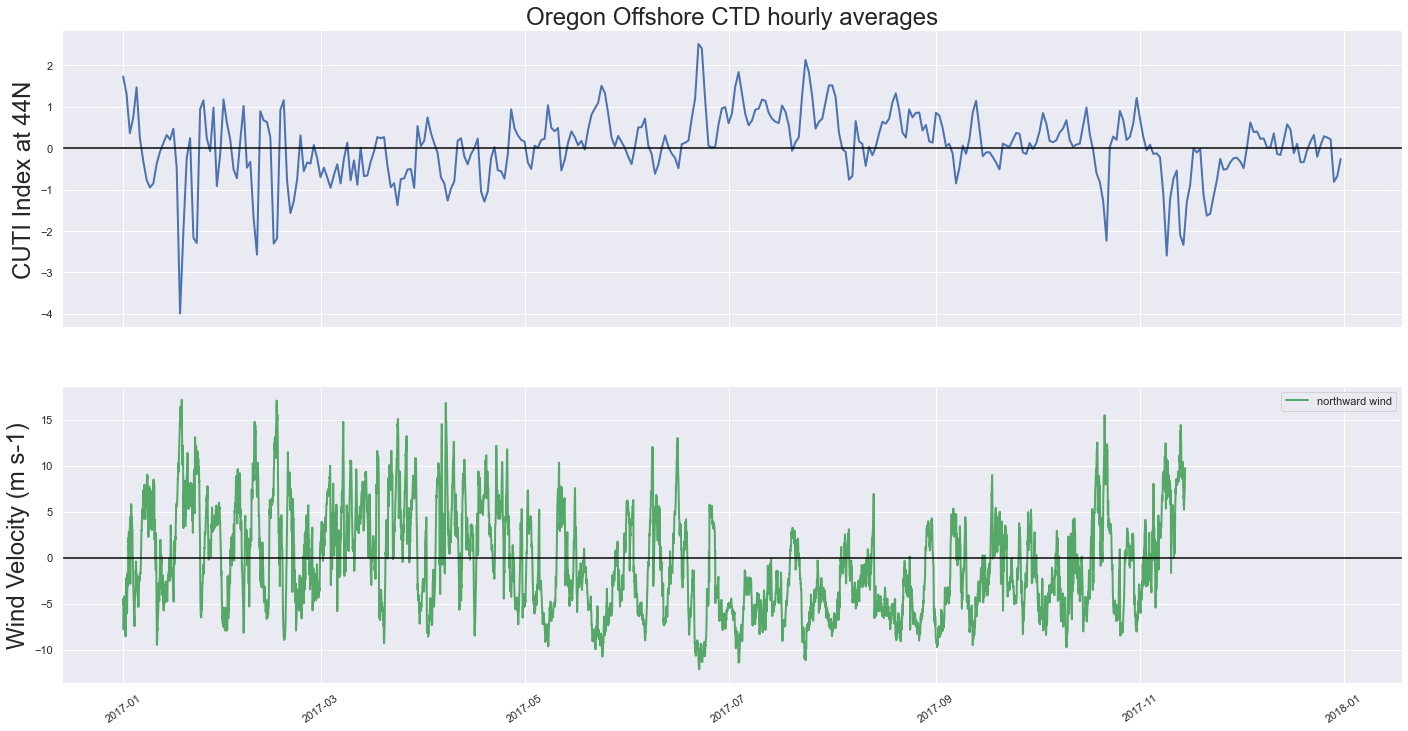

In [75]:
# Plot hourly-averaged METBK data
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
ax1.plot(cuti['time'], cuti['44N'], 'b', linewidth=2)
ax1.set_xlabel('')
ax1.set_ylabel('CUTI Index at 44N', size=24)
ax1.set_title('Oregon Offshore CTD hourly averages', size=24)
ax1.axhline(y=0, ls='-', c='black') # add horizontal line at 0

#ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['Northward Wind Velocity (m s-1)'], 'g', label='northward wind', linewidth=2)
ax2.set_ylabel('Wind Velocity ({})'.format(METBK_units['met_windavg_mag_corr_north'][0]), size=24)
ax2.legend()
ax2.axhline(y=0, ls='-', c='black') # add horizontal line at 0

plt.xticks(rotation=35);

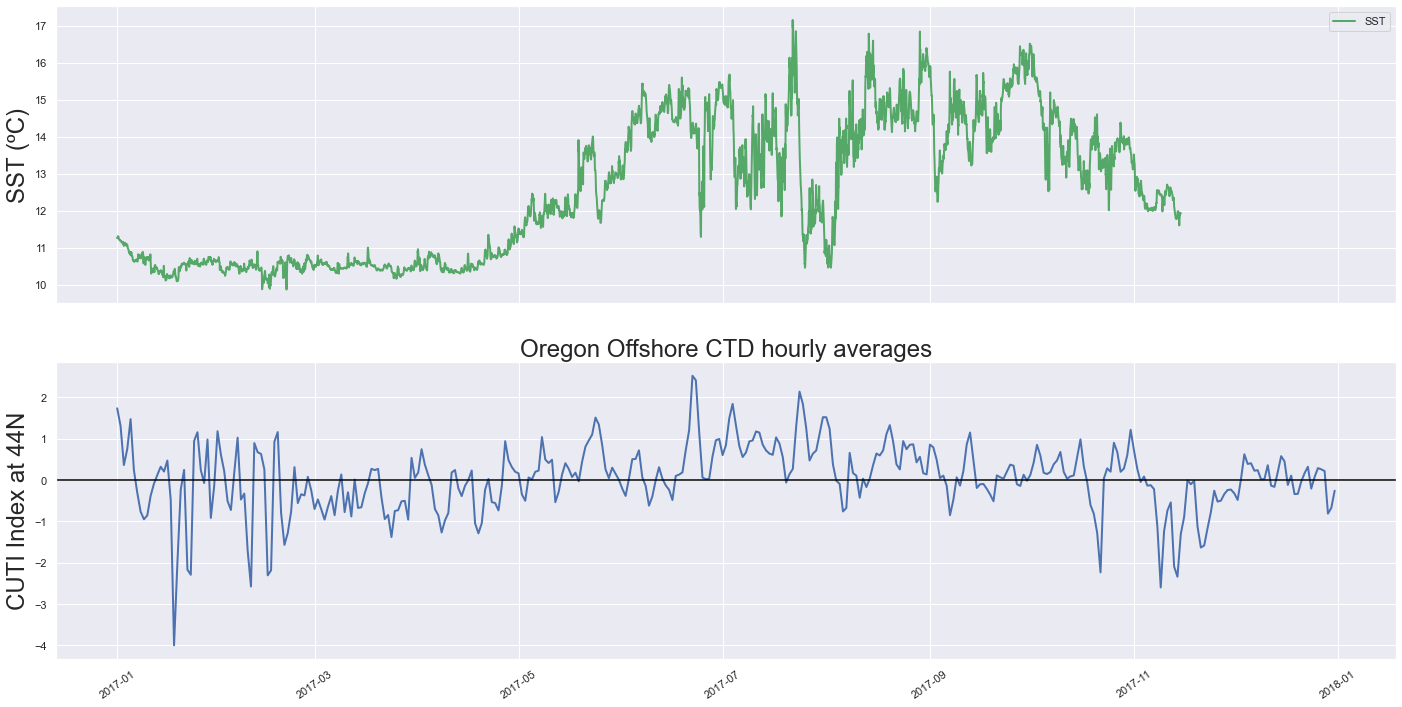

In [81]:
# Plot hourly-averaged METBK data
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, figsize=(24, 12))
ax1.plot(cuti['time'], cuti['44N'], 'b', linewidth=2)
ax1.set_xlabel('')
ax1.set_ylabel('CUTI Index at 44N', size=24)
ax1.set_title('Oregon Offshore CTD hourly averages', size=24)
ax1.axhline(y=0, ls='-', c='black') # add horizontal line at 0

#ax2.plot(METBK_hourly['time'], METBK_hourly['Eastward Wind Velocity (m s-1)'], 'c', label='eastward wind')
ax2.plot(METBK_hourly['time'], METBK_hourly['Sea Surface Temperature (deg_C)'], 'g', label='SST', linewidth=2)
ax2.set_ylabel('SST ({})'.format(METBK_units['sea_surface_temperature'][0]), size=24)
ax2.legend()

plt.xticks(rotation=35);

Nice place to explore CUTI data: https://heatherwelch.shinyapps.io/shiny_jacox_cuti/

--- 
### Save data for modeling

**Be careful saving this data!**

It can save a lot of time BUT it's very easy to accidentally overwrite something that you really needed! 

In [55]:
# METBK_data_copy.to_csv('METBK_01-01_12-01.csv', index=False)
# CTD_data_copy.to_csv('CTD_01-01_09-16.csv', index=False)

List of dataframes created here: 

'CTD_daily',
'CTD_data',
'CTD_data_copy',
'CTD_hourly',
'CTD_minutes',
'CTD_summer',
'CTD_summer_minutes',
'CTD_week',


'METBK_daily',
'METBK_data',
'METBK_data_copy',
'METBK_hourly',
'METBK_minutes',
'METBK_summer_data',
'METBK_summer_minutes'

In [122]:
CTD_five_minutes = CTD_data.resample('5T', on='time').mean().dropna(how='all').reset_index()
METBK_five_minutes = METBK_data_copy.resample('5T', on='time').mean().dropna(how='all').reset_index()

In [123]:
METBK_five_minutes

,time,sea_surface_temperature,met_windavg_mag_corr_east,met_windavg_mag_corr_north
0,2017-01-01 00:00:00,11.2706,4.508827e+00,-5.379293e+00
1,2017-01-01 00:05:00,11.2734,3.565842e+00,-5.104888e+00
2,2017-01-01 00:10:00,11.2684,4.480898e+00,-4.276227e+00
3,2017-01-01 00:15:00,11.2688,4.445523e+00,-4.517499e+00
4,2017-01-01 00:20:00,11.2664,3.978126e+00,-4.948819e+00
...,...,...,...,...
96408,2017-12-01 18:10:00,12.0454,-1.228042e+07,-7.013654e+06
96409,2017-12-01 18:15:00,12.0476,-1.228042e+07,-7.013654e+06
96410,2017-12-01 18:20:00,12.0498,-1.228042e+07,-7.013654e+06
96411,2017-12-01 18:25:00,12.0526,-1.228042e+07,-7.013654e+06


In [125]:
CTD_five_minutes

,time,seawater_pressure,practical_salinity,seawater_temperature,corrected_dissolved_oxygen,lat,lon
0,2017-01-01 00:00:00,200.443063,33.887095,7.782278,106.538309,44.37415,-124.95648
1,2017-01-01 00:05:00,200.390905,33.887016,7.783830,106.473931,44.37415,-124.95648
2,2017-01-01 00:10:00,200.341566,33.887443,7.783282,106.329082,44.37415,-124.95648
3,2017-01-01 00:15:00,200.300686,33.887857,7.781079,106.232525,44.37415,-124.95648
4,2017-01-01 00:20:00,200.246572,33.890147,7.763354,105.977270,44.37415,-124.95648
...,...,...,...,...,...,...,...
71742,2017-09-16 11:50:00,269.405700,33.965714,7.227581,85.537419,44.37415,-124.95648
71743,2017-09-16 11:55:00,201.202692,33.924119,7.880886,97.002159,44.37415,-124.95648
71744,2017-09-16 12:00:00,97.638500,33.738392,9.066732,143.117259,44.37415,-124.95648
71745,2017-09-16 12:05:00,49.993728,33.371898,10.085181,186.610283,44.37415,-124.95648


In [116]:
ds_list = [CTD_daily, CTD_data, CTD_data_copy, CTD_hourly, CTD_minutes, 
            CTD_summer, CTD_summer_minutes, CTD_week, CTD_five_minutes, 
            METBK_daily, METBK_data, METBK_data_copy, METBK_hourly, METBK_minutes, 
            METBK_summer_data, METBK_summer_minutes, METBK_five_minutes]

for ds in ds_list:
    print(ds.shape)

(253, 7)
(21517483, 7)
(21517483, 7)
(5984, 7)
(358673, 7)
(5182339, 7)
(86384, 7)
(431988, 7)
(71747, 7)
(318, 4)
(460984, 4)
(485137, 4)
(7632, 4)
(427289, 4)
(2208, 4)
(81224, 4)
(91582, 4)


In [126]:
# CTD_daily.to_csv('CTD_daily.csv', index=False)
# METBK_daily.to_csv('METBK_daily.csv', index=False)

In [124]:
# CTD_five_minutes.to_csv('CTD_five_minutes.csv', index=False)
# METBK_five_minutes.to_csv('METBK_five_minutes.csv', index=False)

In [128]:
# cuti.to_csv('cuti.csv', index=False)

In [107]:
# dir()

In [ ]:
# METBK_hourly.to_csv('METBK_03-01_06_30.csv', index=False)
# CTD_data.to_csv('CTD_03-01_06_30.csv', index=False)

Reevaluate all the dataframes I've made here and choose which ones I want to carry over to the modeling.

In [131]:
CTD_data['seawater_pressure'].describe()

count    2.151748e+07
mean     1.892278e+02
std      3.956323e+01
min      1.355533e+01
25%      2.026819e+02
50%      2.037541e+02
75%      2.044697e+02
max      2.906436e+02
Name: seawater_pressure, dtype: float64